In [74]:
import numpy as np
import pandas as pd
from importlib import reload
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shared
import config
import provider_yfinance as provider
import model
import plot

reload(shared)
reload(config)
reload(provider)
reload(model)
reload(plot)

plot.Notebook()

mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

cfg = config.get_config('^GDAXI')

# overwrite download_end_dt: use cached data
# config.overwrite_end_dt(cfg, '2019-12-19')
# config.save_config(cfg)

config> created config from file: './config.json'
config> config
        - base:
            - config_file_path: /mnt/c/notebooks/sandbox/config.json
        - datasets:
            - stocks: 30
            - benchmarks: 69
        - prepare:
            - data_start_dt: 2018-02-10
            - data_end_dt: 2020-01-07
            - cache_dir: /mnt/c/notebooks/sandbox/cache/20200107/
        - train:            
            - window_trading_days: [3, 5, 21, 35, 50]
            - lag_trading_days: [1, 2, 3, 4, 5]
            - label_max_high_weight: 3.0
            - label_max_close_weight: 1.0
            - settings: 12
        - model:
            - max_samples: 40
            - batch_size: 200
            - lstm_hidden_size: 256
            - early_stopping_patience: 10
            - validaion_monitor: val_mean_squared_error
            - max_epochs: 1000
            - base_dir: /mnt/c/notebooks/sandbox/model/20200107/            
        


In [76]:
eval_result = {}
for submodel_settings in cfg.train.settings:
    print(f'eval> process {submodel_settings.id} ...')
    eval_result[submodel_settings.id] = {}
    mdl_data = provider.prepare_submodel_data(cfg, submodel_settings)
    tickers = mdl_data.ticker.unique().tolist()
    for ticker_name in tickers:
        ticker_data = mdl_data[mdl_data.ticker==ticker_name]
        mdl = model.create_model(cfg, submodel_settings, ticker_data, ticker_name, train_mode=False)
        mdl0 = model.create_model(cfg, submodel_settings, ticker_data, train_mode=False)
        print(f'eval> ... {submodel_settings.id} - {ticker_name} - ticker model: ', end='')
        num_samples = ticker_data.shape[0]    
        num_features = len(ticker_data.X.head(1).tolist()[0][0][0][0])
        input_dim = num_features    
        input_length = submodel_settings.lookback_days
        output_dim = 1
        X = np.hstack(np.asarray(ticker_data.X)).reshape(num_samples, input_length, input_dim)
        y = np.hstack(np.asarray(ticker_data.y)).reshape(num_samples, output_dim)
        print(dict(zip(mdl.metrics_names, mdl.evaluate(X, y, verbose=1))))
        print(f'eval> ... {submodel_settings.id} - {ticker_name} - overall model: ', end='')
        X0 = np.hstack(np.asarray(ticker_data.X)).reshape(num_samples, input_length, input_dim)
        y0 = np.hstack(np.asarray(ticker_data.y)).reshape(num_samples, output_dim)
        print(dict(zip(mdl.metrics_names, mdl0.evaluate(X0, y0, verbose=1))))
        break

eval> process lookback_3-label_1 ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_21 (Batc (None, 3, 1319)           5276      
_________________________________________________________________
masking_21 (Masking)         (None, 3, 1319)           0         
_________________________________________________________________
lstm_61 (LSTM)               (None, 3, 256)            1613824   
_________________________________________________________________
lstm_62 (LSTM)               (None, 3, 256)            525312    
_________________________________________________________________
lstm_63 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 2,669,981
Trainable params: 2,667,343
Non-trainable params: 2,638
_________________________

BaseException: sm-lookback_3-label_2> Missing submodel data!

199/199 [==============================] - 5s 26ms/step


{'loss': 1.0107606140213397,
 'mean_absolute_error': 0.7137107465734434,
 'mean_squared_error': 1.0107606140213397}

199/199 [==============================] - 1s 3ms/step


{'loss': 0.7361454234491266,
 'mean_absolute_error': 0.6471053865087691,
 'mean_squared_error': 0.7361454234491266}

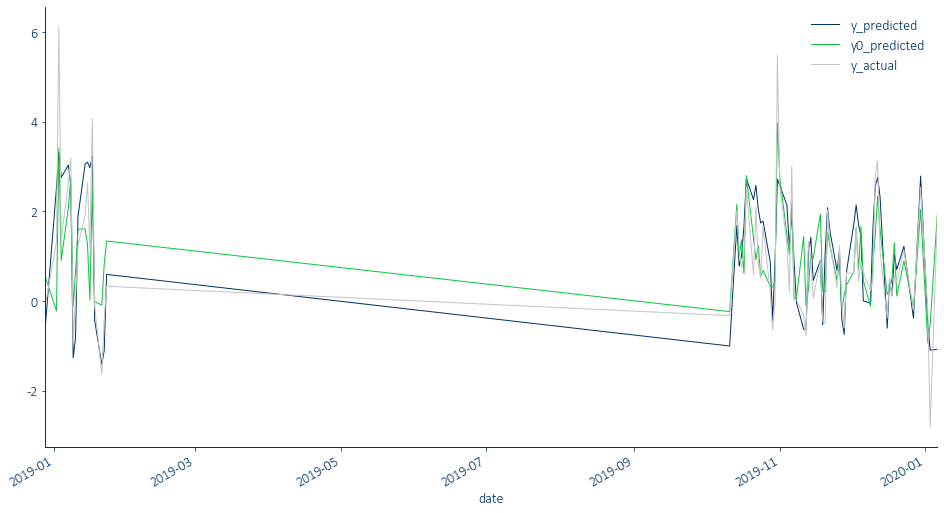

In [69]:
df_test = pd.DataFrame({
    'y_predicted': pd.Series(mdl.predict(X).flatten()),
    'y0_predicted': pd.Series(mdl0.predict(X0).flatten()),
    'y_actual': ticker_data.y
})
df_test.index = ticker_data.date
df_test.plot()

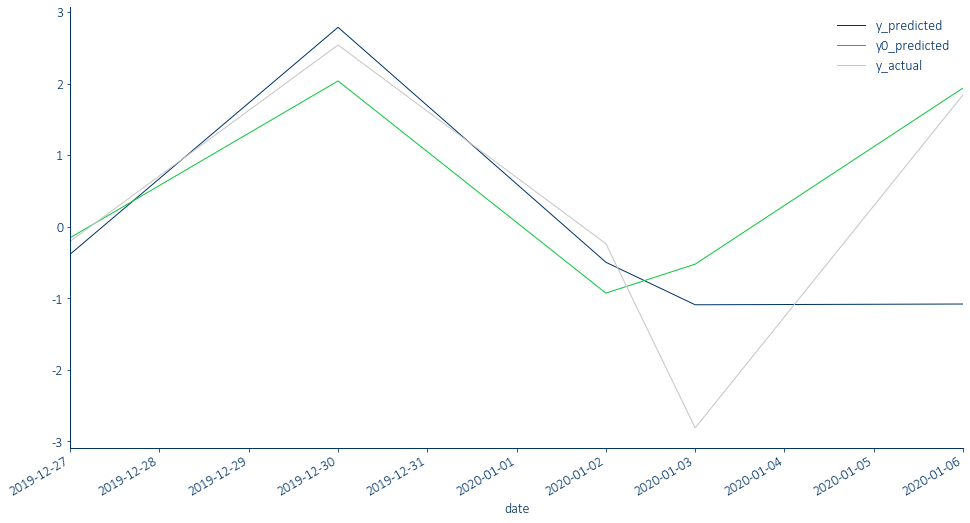

In [70]:
df_test.tail(cfg.model.max_samples-10).plot()

In [ ]:
1 ticker
-> 12 submodel_settings
-> 24 models (ticker + overall)
-> weights per model
x1*m1t + 

